In [12]:
! py -m pip install mlxtend --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.4.1 requires packaging<22.0,>=0.21, but you have packaging 23.2 which is incompatible.



  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 1.4/1.4 MB 23.2 MB/s eta 0:00:00
   ---------------------------------------- 11.1/11.1 MB 18.8 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.1.7
    Uninstalling mlxtend-0.1.7:
      Successfully uninstalled mlxtend-0.1.7


## LLM

In [1]:
import sqlite3
import pandas as pd
from langchain.agents import tool
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import AzureChatOpenAI
from prompts import *
import re
from typing import Literal
import sqlite3, json
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain.agents import tool
from langchain import OpenAI  # or your AzureChatOpenAI wrapper
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import display, Image

conn = sqlite3.connect("cross_selling.db")

@tool
def fetch_customer_profile(name: str) -> str:
    """Fetch basic customer profile by full name."""
    df = pd.read_sql(f"SELECT * FROM customers WHERE First_Name || ' ' || Last_Name = '{name}'", conn)
    return df.to_json(orient="records") if not df.empty else "Customer not found."

@tool
def analyze_customer_behavior(customer_id: str) -> str:
    """Provides a detailed analysis of customer behavior, spending patterns, and financial signals."""
    df = pd.read_sql(f"SELECT * FROM feature_store WHERE Customer_ID = '{customer_id}'", conn)
    if df.empty:
        return "No behavior data found for this customer."
    
    row = df.iloc[0]
    insights = []

    # 1️⃣ Aggregation Period
    insights.append(f"Analysis based on {row['Aggregation_Days']} days of transaction data.")

    # 2️⃣ Spending Overview
    insights.append(f"Total spending during this period is ${row['Total_Spend']:.2f} across {row['Num_Transactions']} transactions.")
    insights.append(f"Average transaction amount is ${row['Avg_Txn_Amount']:.2f}, with a maximum single transaction of ${row['Max_Txn_Amount']:.2f}.")
    
    # 3️⃣ Key Spending Categories
    category_flags = []
    if row.get("Spend_Grocery", 0) > 500:
        category_flags.append(f"Grocery: ${row['Spend_Grocery']:.2f}")
    if row.get("Spend_Travel", 0) > 800:
        category_flags.append(f"Travel: ${row['Spend_Travel']:.2f}")
    if row.get("Spend_Fuel", 0) > 150:
        category_flags.append(f"Fuel: ${row['Spend_Fuel']:.2f}")
    if row.get("Spend_Medical", 0) > 200:
        category_flags.append(f"Medical: ${row['Spend_Medical']:.2f}")
    if row.get("Spend_Entertainment", 0) > 300:
        category_flags.append(f"Entertainment: ${row['Spend_Entertainment']:.2f}")

    if category_flags:
        insights.append("Significant spending detected in categories: " + "; ".join(category_flags))
    else:
        insights.append(f"Primary spending category is {row['Top_Spend_Category']}.")

    # 4️⃣ Income & Salary Patterns
    if row["Has_Salary_Credit"]:
        insights.append("Regular salary deposits detected, indicating stable income.")
    if row["Salary_to_Spend_Ratio"] > 0.5:
        insights.append(f"Healthy disposable income, with a Salary-to-Spend Ratio of {row['Salary_to_Spend_Ratio']:.2f}.")

    # 5️⃣ Financial Profile
    if row["Annual_Income"] > 100000:
        insights.append(f"High annual income: ${row['Annual_Income']}.")
    elif row["Annual_Income"] > 60000:
        insights.append(f"Moderate annual income: ${row['Annual_Income']}.")

    if row["Credit_Score"] >= 750:
        insights.append(f"Excellent credit score: {row['Credit_Score']}.")
    elif row["Credit_Score"] >= 700:
        insights.append(f"Good credit score: {row['Credit_Score']}.")
    else:
        insights.append(f"Credit score is {row['Credit_Score']}.")

    # 6️⃣ Spend Variability
    if row["Spend_Variability"] > 500:
        insights.append(f"High variability in spending, suggesting inconsistent transaction amounts.")
    else:
        insights.append(f"Consistent spending behavior with low variability.")

    # 7️⃣ Idle Balance Potential
    if row["Idle_Balance_Estimate"] > 5000:
        insights.append(f"Estimated idle balance of ${row['Idle_Balance_Estimate']:.2f}, indicating potential for savings or investment products.")

    return " | ".join(insights)

@tool
def fetch_product_catalog(dummy_input: str) -> str:
    """Returns the bank's product catalog for cross-selling."""
    df = pd.read_sql("SELECT * FROM products", conn)
    return df.to_json(orient="records")


@tool
def scientific_calculator(expression: str) -> str:
    """Performs safe scientific calculations. Provide expressions like '1250 / 28' or 'sqrt(256)'."""
    import math
    allowed_names = {k: v for k, v in math.__dict__.items() if not k.startswith("__")}
    allowed_names['abs'] = abs

    try:
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error in calculation: {str(e)}"

@tool
def fetch_owned_products(customer_id: str) -> str:
    """
    Fetches the list of products currently owned by the customer.
    The LLM should avoid recommending these products again.
    """
    query = f"""
            SELECT p.Product_ID, p.Product_Name, p.Product_Type
            FROM customer_products cp
            JOIN products p ON cp.Product_ID = p.Product_ID
            WHERE cp.Customer_ID = '{customer_id}'
        """
    df = pd.read_sql(query, conn)
    
    if df.empty:
        return "This customer does not own any products currently."
    
    # Return a readable list
    owned_list = df[['Product_ID', 'Product_Name', 'Product_Type']].to_dict(orient='records')
    return f"Customer currently owns the following products: {owned_list}"

@tool
def fetch_schema_info(dummy_input: str = "") -> str:
    """
    Returns the pre‐built SCHEMA_INFO string describing your database schema.
    """
    return SCHEMA_INFO


@tool
def run_sql(input: str) -> str:
    """
    Executes one or more semicolon-separated SQL statements against `conn`.
    - SELECT queries: returns top 5 rows as a markdown table.
    - Other queries: returns success/failure status.
    """
    try:
        payload = json.loads(input)
        sql_statements = payload.get("sql_statements", "")
    except json.JSONDecodeError:
        sql_statements = input

    outputs = []
    for stmt in sql_statements.split(";"):
        stmt = stmt.strip()
        if not stmt:
            continue
        try:
            if stmt.lower().startswith("select"):
                df = pd.read_sql(stmt, conn)
                if df.empty:
                    outputs.append(f"✅ `{stmt}` returned no rows.")
                else:
                    table = df.to_markdown(index=False)
                    outputs.append(f"✅ Results for `{stmt}`:\n\n{table}")
            else:
                conn.execute(stmt)
                conn.commit()
                outputs.append(f"✅ Executed `{stmt}` successfully.")
        except Exception as e:
            outputs.append(f"❌ Error executing `{stmt}`:\n{str(e)}")
    return "\n\n".join(outputs)

@tool
def clean_sql_statement(raw_sql: str) -> str:
    """
    Strips out markdown fences (```sql``` or ```), any leading/trailing backticks,
    and excessive whitespace so you get a clean SQL string.
    """
    # Remove opening fences like ```sql or ``` and closing ```
    cleaned = re.sub(r"```(?:sql)?\s*", "", raw_sql)
    cleaned = cleaned.replace("```", "")
    # Collapse any multiple newlines/spaces
    cleaned = re.sub(r"\s*\n\s*", " ", cleaned)
    # Remove trailing semicolon if desired (we’ll handle semis in run_sql)
    cleaned = cleaned.strip().rstrip(";")
    return cleaned


In [2]:
fetch_customer_profile.description = "Fetch the customer's demographic and financial profile by full name."

fetch_product_catalog.description = "Retrieve the complete product catalog including features, target behaviors, eligibility criteria, and special offers."

fetch_owned_products.description = "Get a list of products already owned by the customer to avoid duplicate recommendations. Accepts Customer_ID , e.g. 'CUST0012'"

scientific_calculator.description = "Perform numeric calculations such as averages, ratios, or thresholds to support financial reasoning."

fetch_schema_info.description = (
    "Use this tool to retrieve the database schema (tables, columns, types) "
    "Use this tool for any doubts with tables"
)

run_sql.description = (
    "Use this tool to execute raw SQL statements. "
    "Accepts one or multiple semicolon-separated queries. "
    "Use this tool to resolve data related doubts in Thoughts"
    "use fetch_schema tool before using this tool"
)

analyze_customer_behavior.description = (
    "Only use this if you have Customer ID"
    "Use this ONLY to summarize customer behavior patterns for making product recommendations. "
    "Do NOT use this tool to answer specific data questions like amounts spent."
    "Accepts Customer_ID , e.g. 'CUST0012'"
)

clean_sql_statement.description = (
    "Use this tool to take any raw SQL (even wrapped in markdown fences) "
    "and return a single clean SQL string, ready for execution." )

In [3]:
# OPENAI_DEPLOYMENT_ENDPOINT = "https://pkl-aa-dev-aiservices.openai.azure.com/" 
# OPENAI_API_KEY = "AXEC3y1jC9ZNGCBB12NZwrpBSzScq1esexgvCXiqw7PaHE04vSMbJQQJ99BDACYeBjFXJ3w3AAABACOG4CMN" 
# OPENAI_API_VERSION = "2024-12-01-preview"

# OPENAI_DEPLOYMENT_NAME = "gpt-4o"
# OPENAI_MODEL_NAME="gpt-4o"


# llm = AzureChatOpenAI(
#                         temperature=0.1,
#                         deployment_name=OPENAI_DEPLOYMENT_NAME,
#                         model_name=OPENAI_MODEL_NAME,
#                         azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
#                         openai_api_version=OPENAI_API_VERSION,
#                         openai_api_key=OPENAI_API_KEY            
#                     )

In [4]:
OPENAI_DEPLOYMENT_ENDPOINT = "https://az-openai-document-question-answer-service.openai.azure.com/" 
OPENAI_API_KEY = "5d24331966b648738e5003caad552df8" 
OPENAI_API_VERSION = "2023-05-15"

OPENAI_DEPLOYMENT_NAME = "az-gpt_35_model"
OPENAI_MODEL_NAME="gpt-3.5-turbo"

OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME = "az-embedding_model" 
OPENAI_ADA_EMBEDDING_MODEL_NAME = "text-embedding-ada-002"

encoding_name = "cl100k_base"

llm = AzureChatOpenAI(
                        temperature=0.1,
                        deployment_name=OPENAI_DEPLOYMENT_NAME,
                        model_name=OPENAI_MODEL_NAME,
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
                        openai_api_version=OPENAI_API_VERSION,
                        openai_api_key=OPENAI_API_KEY            
                    )

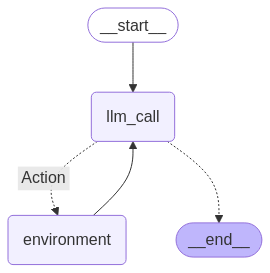

In [5]:
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 1) Your LLM + tools binding
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
tools = [fetch_schema_info, run_sql  , clean_sql_statement,analyze_customer_behavior, fetch_owned_products]
llm_with_tools = llm.bind_tools(tools)
tools_by_name  = {t.name: t for t in tools}

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 2) llm_call node: invoke LLM (it may emit tool calls)
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        agent_prompt_workflow
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 5) Build & compile the StateGraph
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call",    llm_call)
agent_builder.add_node("environment", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {"Action": "environment", END: END}
)
agent_builder.add_edge("environment", "llm_call")

agent = agent_builder.compile()

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 6) Visualize & invoke
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
def format_recommendation_summary(raw_text):
    # Remove initial label if present
    raw_text = raw_text.replace("**Recommendation Summary:**", "").strip()

    # Split by numbering (assuming '1.' and '2.' structure)
    parts = raw_text.split(" 2. ")
    rec_1 = parts[0].strip()
    rec_2 = parts[1].strip() if len(parts) > 1 else ""

    formatted_output = ""

    for idx, rec in enumerate([rec_1, rec_2], start=1):
        if not rec:
            continue
        # Split the recommendation into lines by bullet points
        lines = rec.split(" - ")
        title = lines[0].strip()
        bullets = lines[1:]

        formatted_output += f"{idx}. {title}\n"
        for bullet in bullets:
            bullet = bullet.replace("Eligibility Criteria", "Eligibility Criteria") \
                           .replace("Reason", "Reason") \
                           .replace("Benefit", "Benefit")
            formatted_output += f"   - {bullet.strip()}\n"
        formatted_output += "\n"

    return textwrap.dedent(formatted_output)

In [7]:
msgs   = [HumanMessage(content="Analyze Kevin Fleming's spending patterns. Which products did they buy ? What was the highest expenditure on?")]
result = agent.invoke({"messages": msgs})

for m in result["messages"]:
    m.pretty_print()


================================ Human Message =================================

Analyze Kevin Fleming's spending patterns. Which products did they buy ? What was the highest expenditure on?
================================== Ai Message ==================================
Tool Calls:
  analyze_customer_behavior (call_1aJnVHX5mz4ADp7HRFXP79sI)
 Call ID: call_1aJnVHX5mz4ADp7HRFXP79sI
  Args:
    customer_id: Kevin Fleming
================================= Tool Message =================================

No behavior data found for this customer.
================================== Ai Message ==================================
Tool Calls:
  fetch_owned_products (call_Px8GqkOOCq4HtpExiJQNabiL)
 Call ID: call_Px8GqkOOCq4HtpExiJQNabiL
  Args:
    customer_id: Kevin Fleming
================================= Tool Message =================================

This customer does not own any products currently.
================================== Ai Message ==================================

Kevin Flem

# Q&A

In [30]:
# user_query = "How much did Kevin Fleming spend in total over how many days?"
# user_query = "Recommend products for Kevin Fleming based on his current products and expenditures."
# user_query = "Give me a view of all transactions by David Brown"
# user_query = "Give me customer info for Mr.Fleming"
# user_query = "How many total customers bought more than 2 products ?"
user_query = "Analyze Kevin Fleming's spending patterns. Which products did they buy ? What was the highest expenditure on?"
response = agent_executor.invoke({"input": user_query})

output_text = response.get('output', '')
print(format_recommendation_summary(output_text))



> Entering new AgentExecutor chain...
Thought: To analyze Kevin Fleming's spending patterns and determine the products they bought, I first need to identify their customer ID. Then, I can check their owned products and analyze their spending behavior.

Action: fetch_schema_info
Action Input: ''
You have access to the following database schema:

---

### 1. **customers**
Stores customer demographic and financial profile information.

| Column Name   | Type    | Description                                | Example         |
|---------------|---------|--------------------------------------------|-----------------|
| Customer_ID   | TEXT PK | Unique customer identifier                 | 'CUST0012'      |
| First_Name    | TEXT    | Customer's first name                      | 'David'         |
| Last_Name     | TEXT    | Customer's last name                       | 'Brown'         |
| Gender        | TEXT    | Customer's gender ('M' or 'F')             | 'M'             |
| Date_of_Birth